In [2]:
!pip install celluloid

In [1]:
%load_ext autoreload
%autoreload 2

warrior:  (0, 1.5)
knight:  (0, 1.5)
warrior:  (0, 2.5)
knight:  (0, 2.5)
warrior:  (0, 3.5)
archer:  (0, 3.5)
warrior:  (10, 6.5)
knight:  (10, 6.5)
warrior:  (10, 7.5)
knight:  (10, 7.5)
warrior:  (10, 8.5)
archer:  (10, 8.5)
snap!
snap!
torch.Size([8, 20, 13])


 95%|█████████▍| 142/150 [00:15<00:00,  9.35it/s]


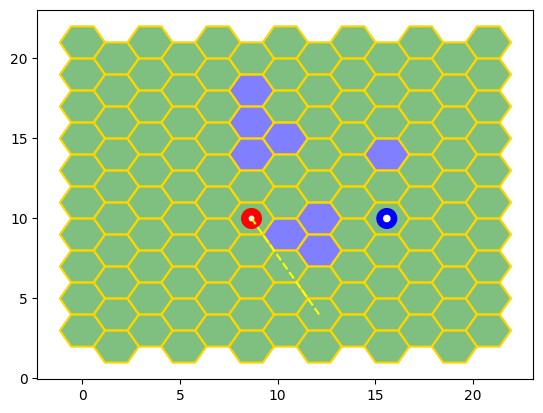

In [2]:
import tqdm

from Game import Game
from objects.Warriors import Archer, Knight
from Brain import ArcherBrain, KnightBrain, PreNet
from graphics.MatplotlibRenderer import MatplotlibRenderer
from map.Map import Map
from Config import Config

import torch

m = Map('static/map.json')
teams = [
            [Knight(pos=(0, 1.5)), Knight(pos=(0, 2.5)), Archer(pos=(0, 3.5))], 
            [Knight(pos=(10, 6.5)), Knight(pos=(10, 7.5)), Archer(pos=(10, 8.5))], 
        ]
config = Config('static/config.json')

plt_assets = {
    'surface' : {
        'none'  : {
            'color' : 'white'
        },
        'water' : {
            'color' : 'blue'
        },
        'ground' : {
            'color' : 'brown'
        },
        'grass' : {
            'color' : 'green'
        }
    },
    'warriors': {
        'archer' : 'red',
        'knight' : 'blue'
    }
}

renderer = MatplotlibRenderer(plt_assets)
game = Game(teams, m, config)
# задаём мозги NPC
h, w = game.field.hex_field.get_size()
w, h = int(w), int((h-0.5)*2)+1
prenet = PreNet(8, h, w)
brain_archer = ArcherBrain(prenet=prenet, return_dist=True)
brain_knight = KnightBrain(prenet=prenet, return_dist=True)

obs = game.reset(max_iter=1000, record=True, renderer=renderer)
mem = torch.zeros(256)
dist, mem = brain_archer(obs, mem)
action = dist.sample().argmax()
action = dist.decode_action(action)
game.step(action)

obs = game.reset(max_iter=1000, record=True, renderer=renderer)
print(obs.shape)
for i in tqdm.tqdm(range(150)):
    dist = None
    match game.warrior.get_info()['class']:
        case 'knight':
            dist, mem = brain_archer(obs, mem)
        case 'archer':
            dist, mem = brain_archer(obs, mem)
    action = dist.sample().argmax()
    action = dist.decode_action(action)
    r, obs, stop = game.step(action)
    if stop == True:
        break
renderer.save()

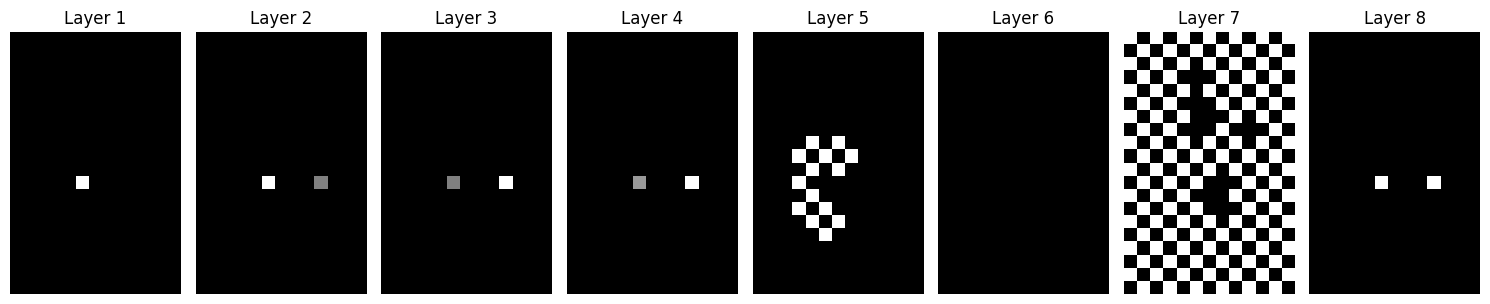

In [3]:
import matplotlib.pyplot as plt

# config = Config('static/config.json')
# game = Game(teams, m, config)
mask = game.observe() # .reset(max_iter=1000, record=False, renderer=None)

num_layers = mask.shape[0]

fig, axes = plt.subplots(1, num_layers, figsize=(15, 5))
for i in range(num_layers):
    axes[i].imshow(mask[i], cmap='gray', interpolation='nearest')
    axes[i].set_title(f'Layer {i + 1}')
    axes[i].invert_yaxis()
    axes[i].axis('off')

plt.tight_layout()

tensor(348) 347 {'type': 'attack', 'params': {'pos': (9, tensor(4.))}}


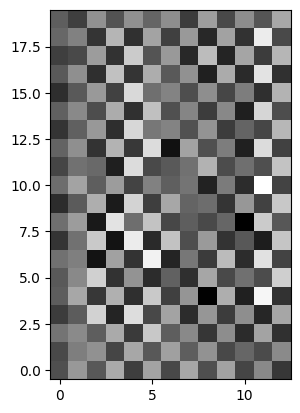

In [4]:
from Brain import ArcherBrain, PreNet, Distribution
import matplotlib.pyplot as plt

h, w = game.field.hex_field.get_size()
w, h = int(w), int((h-0.5)*2)+1
brain = ArcherBrain(prenet=PreNet(8, h, w), return_dist=True)

mem = torch.zeros(256)
dist, mem = brain(game.observe(), mem)

plt.imshow(dist.dist['move']['heat_map'].detach().numpy(), cmap='gray', interpolation='nearest')
plt.gca().invert_yaxis()

# res['params']['heat_map'][:10,:10]

action_ind = dist.sample().argmax()
action = dist.decode_action(action_ind)
action_ind_new = dist.encode_action(action)

print(action_ind, action_ind_new, action)

In [21]:
from map.Map import serializable2map, map2serializable
import json


data = []
with open('static/map.copy.json', 'r', encoding='utf-8') as file:
    data = json.load(file)
with open('static/map.json', 'w', encoding='utf-8') as file:
    m = serializable2map(data)
    for k, item in m['surface'].items():
        m['surface'][k]['speed'] = 0. if m['surface'][k]['s_type'] == 'water' else 1.
    m = map2serializable(m)
    json.dump(m, file)

# PPO

In [5]:
from training.PolicyValueNetwork import PolicyValueNetwork
# input:
#     states - tensor, (batch_size x features)
# output:
#     distribution
#     V - tensor, critic estimation, (batch_size)

In [24]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class Policy:
    def __init__(self, model):
        self.model = model.to(device=DEVICE)

    def act(self, inputs, mem_1, mem_2, training=False):
        """
        input:
            inputs - numpy array if training is False, otherwise tensor, (batch_size x features)
            training - flag, bool
        output:
            if training is True, dict containing keys ['actions', 'log_probs', 'values']:
                `distribution`
                'values' - critic estimations, tensor, (batch_size)
            if training is False, dict containing keys ['actions', 'log_probs', 'values']:
                'actions' - selected actions, numpy, (batch_size)
                'log_probs' - log probs of selected actions, numpy, (batch_size)
                'values' - critic estimations, numpy, (batch_size)
        """
        # if training is false, input is numpy
        if not training:
            inputs = torch.FloatTensor(inputs).to(DEVICE)

        # print(mem_1.shape, mem_2.shape)
        dist, mem_1, mem_2, values = self.model(inputs, mem_1, mem_2)
        actions = dist.sample()
        log_probs = dist.log_prob(actions)
        values = values.flatten()

        if training:
            return {
                "dist": dist,
                "values": values,
                "memory" : (mem_1, mem_2)
            }

        else:
            return {
                "dist": dist,
                "actions": actions.cpu().detach().numpy(),
                "log_probs": log_probs.cpu().detach().numpy(),
                "values": values.cpu().detach().numpy(),
                "memory" : (mem_1, mem_2)
            }

In [7]:
from Brain import ArcherBrain, KnightBrain, ValueNet
from training.GameRunner import GameRunner
from training.PPO import AsArray
from Game import Game

teams = [
            [Knight(pos=(0, 1.5)), Knight(pos=(0, 2.5)), Archer(pos=(0, 3.5))], 
            [Knight(pos=(10, 6.5)), Knight(pos=(10, 7.5)), Archer(pos=(10, 8.5))], 
        ]

config = Config('static/config.json')
game = Game(teams, m, config)
mask = game.reset(max_iter=1000, record=False, renderer=None)

prenet_1 = PreNet(8, h, w)
prenet_2 = PreNet(8, h, w)
# пока только 1 мозг учим
brain_1 = ArcherBrain(prenet=prenet_1, return_dist=True)
brain_2 = ArcherBrain(prenet=prenet_2, return_dist=True)
value_net_1 = ValueNet(prenet=PreNet(8, h, w))
value_net_2 = ValueNet(prenet=PreNet(8, h, w))
model_1 = PolicyValueNetwork(brain_1, value_net_1).to(DEVICE)
model_2 = PolicyValueNetwork(brain_2, value_net_2).to(DEVICE)
policy_1 = Policy(model_1)
policy_2 = Policy(model_1)
game.reset()
runner = GameRunner(game, [policy_1, policy_2], nsteps=10, transforms=[[AsArray()], [AsArray()]])
trajectory = runner.get_next()
print(trajectory.keys())

warrior:  (0, 1.5)
knight:  (0, 1.5)
warrior:  (0, 2.5)
knight:  (0, 2.5)
warrior:  (0, 3.5)
archer:  (0, 3.5)
warrior:  (10, 6.5)
knight:  (10, 6.5)
warrior:  (10, 7.5)
knight:  (10, 7.5)
warrior:  (10, 8.5)
archer:  (10, 8.5)
dict_keys(['actions', 'dist', 'log_probs', 'values', 'observations', 'rewards', 'dones'])


In [8]:
print(type(trajectory['actions']), trajectory['actions'])
print(type(trajectory['dist']), trajectory['dist'].shape)
print(type(trajectory['log_probs']), trajectory['log_probs'])
print(type(trajectory['values']), trajectory['values'])
print(type(trajectory['observations']), trajectory['observations'].shape)
print(type(trajectory['rewards']), trajectory['rewards'])
print(type(trajectory['dones']), trajectory['dones'])
{k: v.shape for k, v in trajectory.items()}

<class 'numpy.ndarray'> [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<class 'numpy.ndarray'> (5,)
<class 'numpy.ndarray'> [-6.1989427 -6.6608806 -6.5581083 -6.138061  -6.2768493]
<class 'numpy.ndarray'> [[0.23027611]
 [0.21744572]
 [0.132569  ]
 [0.1251305 ]
 [0.16667682]]
<class 'numpy.ndarray'> (5, 8, 20, 13)
<class 'numpy.ndarray'> [ 0 -1  0  0 -1]
<class 'numpy.ndarray'> [False False False False False]


{'actions': (5, 521),
 'dist': (5,),
 'log_probs': (5,),
 'values': (5, 1),
 'observations': (5, 8, 20, 13),
 'rewards': (5,),
 'dones': (5,)}

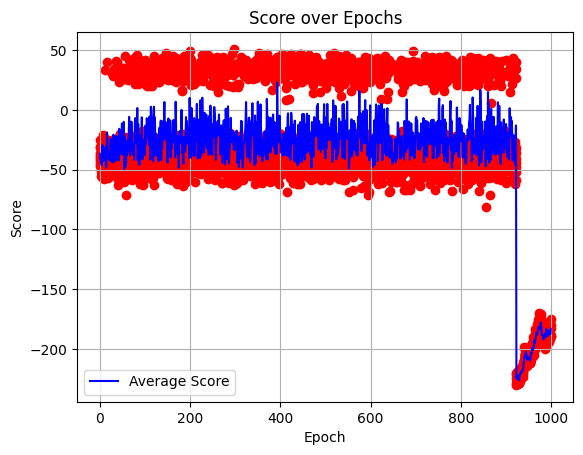

100%|██████████| 1000/1000 [3:27:07<00:00, 12.43s/it]


In [ ]:
import sys
import numpy as np
import pandas as pd

from training.GAE import GAE
from training.PPO import Sampler, NormalizeAdvantages, PyTorchify, make_ppo_sampler, PPO
from utils import evaluate_reward, plot_scores

prenet_1 = PreNet(8, h, w)
prenet_2 = PreNet(8, h, w)
# пока только 1 мозг учим
brain_1 = ArcherBrain(prenet=prenet_1, return_dist=True)
brain_2 = KnightBrain(prenet=prenet_2, return_dist=True)
value_net_1 = ValueNet(prenet=PreNet(8, h, w))
value_net_2 = ValueNet(prenet=PreNet(8, h, w))
model_1 = PolicyValueNetwork(brain_1, value_net_1).to(DEVICE)
model_2 = PolicyValueNetwork(brain_2, value_net_2).to(DEVICE)
policy_1 = Policy(model_1)
policy_2 = Policy(model_1)
sampler = make_ppo_sampler(game, policy_1, policy_2, num_runner_steps=512, num_epochs=5, num_minibatches=64)

# минимизируем лосс
optimizer = torch.optim.AdamW(model_1.parameters(), lr=2e-4, eps=1e-05, maximize=False)
ppo = PPO(policy_1, optimizer, sampler)

import tqdm
NUM_ITERATIONS = 1000
NUM_EVAL = 5

plt.ion()
fig = plt.figure(figsize=(10, 5))
scores = []
all_scores_y = []
all_scores_x = []
for iteration in tqdm.tqdm(range(NUM_ITERATIONS)):
    for batch in sampler.get_next():
        # print(batch)
        ppo.step(batch)

    # print("evaluation")
    sessions = evaluate_reward(game, [policy_1, policy_2], n_games=NUM_EVAL)
    score = sessions.mean()
    scores.append(score)
    all_scores_y.extend(sessions)
    all_scores_x.extend([len(scores)-1]*NUM_EVAL)

    plt.figure(fig.number)  # Используем существующую фигуру
    plot_scores(scores, pd.DataFrame({'x' : all_scores_x, 'y' : all_scores_y}))
    sys.stdout.flush()

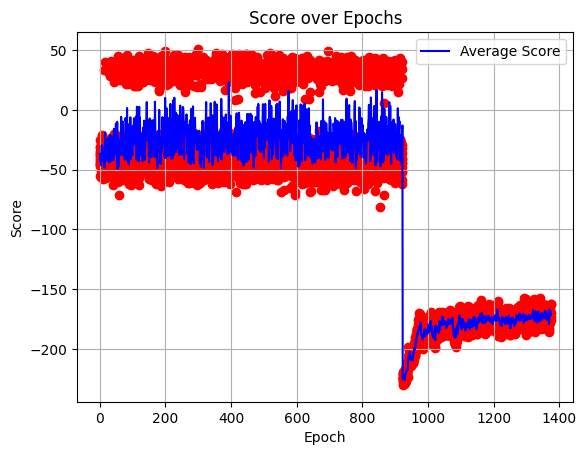

 12%|█▎        | 375/3000 [4:24:53<30:54:15, 42.38s/it]


KeyboardInterrupt: 

In [29]:
NUM_ITERATIONS = 3000
NUM_EVAL = 5

for iteration in tqdm.tqdm(range(NUM_ITERATIONS)):
    for batch in sampler.get_next():
        # print(batch)
        ppo.step(batch)

    # print("evaluation")
    sessions = evaluate(game, [policy_1, policy_2], n_games=NUM_EVAL)
    score = sessions.mean()
    scores.append(score)
    all_scores_y.extend(sessions)
    all_scores_x.extend([len(scores)-1]*NUM_EVAL)

    plt.figure(fig.number)  # Используем существующую фигуру
    plot_scores(scores, pd.DataFrame({'x' : all_scores_x, 'y' : all_scores_y}))
    sys.stdout.flush()

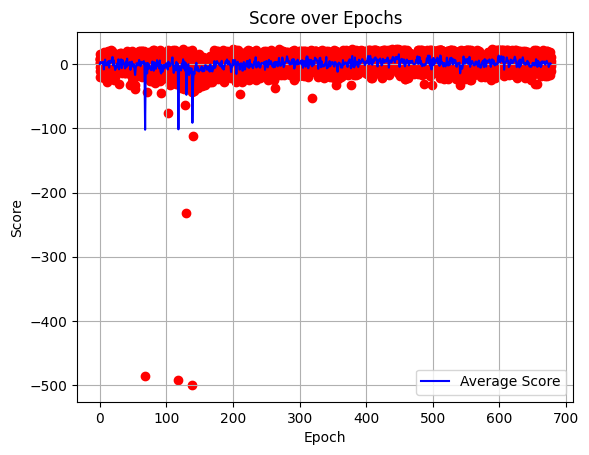

 68%|██████▊   | 678/1000 [1:40:00<47:29,  8.85s/it]


KeyboardInterrupt: 

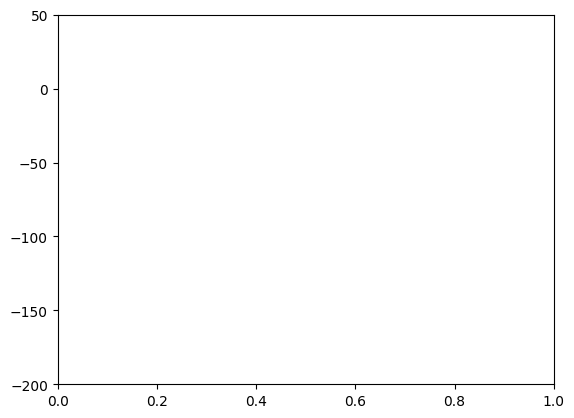

In [22]:
scores = []
all_scores_y = []
all_scores_x = []
NUM_ITERATIONS = 1000
for iteration in tqdm.tqdm(range(NUM_ITERATIONS)):
    for batch in sampler.get_next():
        # print(batch)
        ppo.step(batch)

    # print("evaluation")
    sessions = evaluate(game, [policy_1, policy_2], n_games=NUM_EVAL)
    score = sessions.mean()
    scores.append(score)
    all_scores_y.extend(sessions)
    all_scores_x.extend([len(scores)-1]*NUM_EVAL)

    plt.figure(fig.number)  # Используем существующую фигуру
    plot_scores(scores, pd.DataFrame({'x' : all_scores_x, 'y' : all_scores_y}))
    plt.ylim(-200, 50)
    sys.stdout.flush()

In [29]:
policy_1.model.value

ValueNet(
  (value_head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=66560, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (prenet): PreNet(
    (conv1_1): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(8, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv1_3): Conv2d(8, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (conv1_4): Conv2d(8, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (conv_1x1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [30]:
torch.save(policy_1.model.policy.prenet.state_dict(), "static/weights/policy/prenet.pth")
torch.save(policy_1.model.policy.chose_action_head.state_dict(), "static/weights/policy/chose_action_head.pth")
torch.save(policy_1.model.policy.actions_heads_move.state_dict(), "static/weights/policy/actions_heads_move.pth")
torch.save(policy_1.model.policy.actions_heads_attack.state_dict(), "static/weights/policy/actions_heads_attack.pth")

In [31]:
torch.save(policy_1.model.value.prenet.state_dict(), "static/weights/value/prenet.pth")
torch.save(policy_1.model.value.value_head.state_dict(), "static/weights/value/value_head.pth")

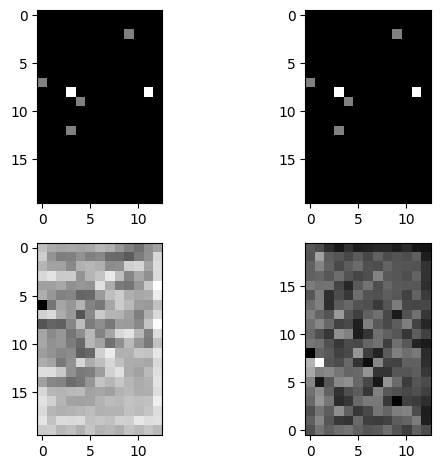

In [37]:
from Brain import ArcherBrain, PreNet, Distribution
import matplotlib.pyplot as plt

h, w = game.field.hex_field.get_size()
w, h = int(w), int((h-0.5)*2)+1
brain = brain_1
with torch.no_grad():
    obs = game.observe()
    dist = brain(obs.to('cuda'))

fig, axs = plt.subplots(ncols=2, nrows=2)
axs[0, 0].imshow(obs[1], cmap='gray', interpolation='nearest')
axs[0, 1].imshow(obs[1], cmap='gray', interpolation='nearest')
axs[1, 0].imshow(dist.dist['move']['heat_map'].cpu().detach().numpy(), cmap='gray', interpolation='nearest')
axs[1, 1].imshow(dist.dist['attack']['heat_map'].cpu().detach().numpy(), cmap='gray', interpolation='nearest')
plt.gca().invert_yaxis()
plt.tight_layout()

In [44]:
evaluate(game, policy, n_games=20)

array([-496, -495, -494, -496, -496, -496, -490, -495, -495, -496, -494,
       -496, -496, -470, -495, -448, -495, -496, -496, -495])

In [130]:
# evaluation will take some time!
sessions = evaluate(game, policy, n_games=20)
score = sessions.mean()
print(f"Your score: {score}")

ValueError: not enough values to unpack (expected 4, got 3)